In [144]:
import networkx as nx
import numpy as np
import math
from matplotlib import lines
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
import random
import shapefile
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import subprocess
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Data Preparation

## Reading Data

In [145]:
raw_dataset = pd.read_csv('restructured_daily.csv')

In [146]:
raw_dataset

,TRGCODE,HOBLINAME,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,99,Yeshwantapura,12.99,77.52,0.5,0.0,5.0,7.0,0.5,0.0,...,0.0,0.0,0.0,8.0,0.0,15.0,0.5,0.0,0.0,6.5
1,101,Sulepeth,17.40,77.35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102,Aurad,17.44,76.90,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,22.5,9.5,0.0
3,103,Kamalapur,17.58,76.99,0.0,0.0,0.0,7.5,0.0,0.5,...,0.0,0.0,0.0,0.0,4.0,8.5,0.0,1.0,12.5,0.0
4,104,Mahagaon,17.54,76.88,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,17.0,0.0,0.0,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,7841,Sirsi,14.56,74.83,0.0,0.0,0.0,0.2,3.0,0.0,...,0.5,0.0,6.5,2.5,0.0,0.0,0.0,0.0,0.0,10.5
3928,7842,Sirsi,14.57,74.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3929,7843,Sirsi,14.58,74.82,0.0,0.0,0.0,0.5,0.2,0.0,...,2.5,2.5,2.5,1.5,1.5,2.0,1.0,0.0,0.0,3.0
3930,7846,Supa(Joida),15.30,74.54,0.0,0.0,0.0,0.0,0.0,1.3,...,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,33.0


In [147]:
raw_dataset.describe()

,TRGCODE,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,2015-06-07,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
count,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,...,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000
mean,3626.179552,14.388721,76.273548,3.913708,2.664140,2.071312,6.855061,1.137030,0.687996,0.975203,...,0.198932,0.216531,1.465056,1.000407,0.839013,2.029222,0.135249,1.323957,4.067472,9.582579
std,2277.198160,1.640077,0.986107,8.807838,7.963733,7.354733,12.678925,10.119662,3.563426,3.707525,...,1.216795,1.423734,4.978187,3.153658,4.273468,6.710487,1.571676,6.227718,10.418618,13.886600
min,99.000000,11.650000,74.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1498.500000,13.040000,75.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3375.500000,14.000000,76.320000,0.500000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,5359.750000,15.760000,77.040000,3.700000,0.700000,0.000000,8.000000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,2.000000,14.500000
max,7851.000000,18.390000,78.560000,190.500000,84.000000,100.500000,121.500000,586.000000,52.100000,54.500000,...,24.500000,29.000000,55.500000,65.000000,76.000000,131.000000,73.000000,95.000000,108.000000,149.000000


In [153]:
# bias = 1e-2

# meta_columns = ['TRGCODE', 'LATITUDE', 'LONGITUDE', 'HOBLINAME']

# dataset = raw_dataset.copy()

# dataset.loc[:, ~dataset.columns.isin(meta_columns)] = np.log1p(raw_dataset.loc[:, ~dataset.columns.isin(meta_columns)] + bias)

dataset = raw_dataset

In [154]:
dataset

,TRGCODE,HOBLINAME,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,99,Yeshwantapura,12.99,77.52,0.5,0.0,5.0,7.0,0.5,0.0,...,0.0,0.0,0.0,8.0,0.0,15.0,0.5,0.0,0.0,6.5
1,101,Sulepeth,17.40,77.35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102,Aurad,17.44,76.90,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,22.5,9.5,0.0
3,103,Kamalapur,17.58,76.99,0.0,0.0,0.0,7.5,0.0,0.5,...,0.0,0.0,0.0,0.0,4.0,8.5,0.0,1.0,12.5,0.0
4,104,Mahagaon,17.54,76.88,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,17.0,0.0,0.0,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,7841,Sirsi,14.56,74.83,0.0,0.0,0.0,0.2,3.0,0.0,...,0.5,0.0,6.5,2.5,0.0,0.0,0.0,0.0,0.0,10.5
3928,7842,Sirsi,14.57,74.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3929,7843,Sirsi,14.58,74.82,0.0,0.0,0.0,0.5,0.2,0.0,...,2.5,2.5,2.5,1.5,1.5,2.0,1.0,0.0,0.0,3.0
3930,7846,Supa(Joida),15.30,74.54,0.0,0.0,0.0,0.0,0.0,1.3,...,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,33.0


In [155]:
dataset.describe()

,TRGCODE,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,2015-06-07,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
count,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,...,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000
mean,3626.179552,14.388721,76.273548,3.913708,2.664140,2.071312,6.855061,1.137030,0.687996,0.975203,...,0.198932,0.216531,1.465056,1.000407,0.839013,2.029222,0.135249,1.323957,4.067472,9.582579
std,2277.198160,1.640077,0.986107,8.807838,7.963733,7.354733,12.678925,10.119662,3.563426,3.707525,...,1.216795,1.423734,4.978187,3.153658,4.273468,6.710487,1.571676,6.227718,10.418618,13.886600
min,99.000000,11.650000,74.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1498.500000,13.040000,75.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3375.500000,14.000000,76.320000,0.500000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,5359.750000,15.760000,77.040000,3.700000,0.700000,0.000000,8.000000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.000000,2.000000,14.500000
max,7851.000000,18.390000,78.560000,190.500000,84.000000,100.500000,121.500000,586.000000,52.100000,54.500000,...,24.500000,29.000000,55.500000,65.000000,76.000000,131.000000,73.000000,95.000000,108.000000,149.000000


In [156]:
## In start:stop, stop is excluseive
dataset['MEAN'] = dataset.iloc[:, 4:980].mean(axis=1)
dataset['STD'] = dataset.iloc[:, 4:980].std(axis=1)
dataset['MEDIAN'] = dataset.iloc[:, 4:980].median(axis=1)
dataset['IQR'] = dataset.iloc[:, 4:980].quantile(0.75, axis=1) - dataset.iloc[:, 4:980].quantile(0.25, axis=1)

In [157]:
dataset

,TRGCODE,HOBLINAME,LATITUDE,LONGITUDE,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,MEAN,STD,MEDIAN,IQR
0,99,Yeshwantapura,12.99,77.52,0.5,0.0,5.0,7.0,0.5,0.0,...,0.0,15.0,0.5,0.0,0.0,6.5,4.107070,10.348445,0.00,3.000
1,101,Sulepeth,17.40,77.35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.851947,8.830068,0.00,1.000
2,102,Aurad,17.44,76.90,0.0,0.0,0.0,0.0,3.5,0.0,...,0.0,0.5,0.5,22.5,9.5,0.0,4.523053,11.894159,0.00,3.500
3,103,Kamalapur,17.58,76.99,0.0,0.0,0.0,7.5,0.0,0.5,...,4.0,8.5,0.0,1.0,12.5,0.0,4.776639,10.767511,0.00,4.000
4,104,Mahagaon,17.54,76.88,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,17.0,0.0,0.0,2.5,0.0,3.996926,12.301344,0.00,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,7841,Sirsi,14.56,74.83,0.0,0.0,0.0,0.2,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.5,14.738012,24.781632,3.80,18.725
3928,7842,Sirsi,14.57,74.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.763422,13.538448,0.00,4.825
3929,7843,Sirsi,14.58,74.82,0.0,0.0,0.0,0.5,0.2,0.0,...,1.5,2.0,1.0,0.0,0.0,3.0,10.823053,20.011957,1.95,12.900
3930,7846,Supa(Joida),15.30,74.54,0.0,0.0,0.0,0.0,0.0,1.3,...,0.0,0.0,0.0,0.0,0.0,33.0,6.812705,15.985495,0.00,6.500


Text(0, 0.5, 'Frequency')

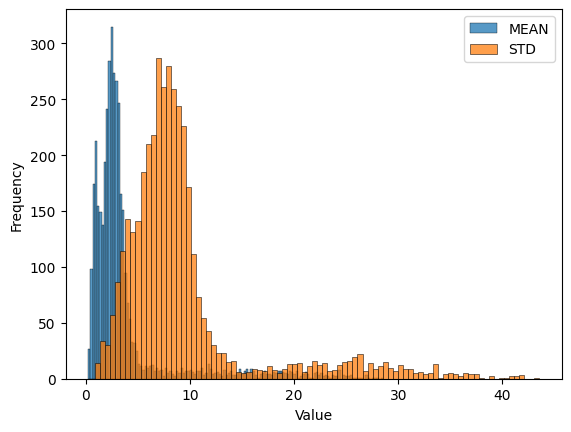

In [158]:
sns.histplot(dataset['MEAN'], label="MEAN")
sns.histplot(dataset['STD'], label="STD")
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")

In [159]:
trgcodes = dataset['TRGCODE'].unique()
print(len(trgcodes))

3932


The randomly selected TRGCODE is 406


<Axes: ylabel='Count'>

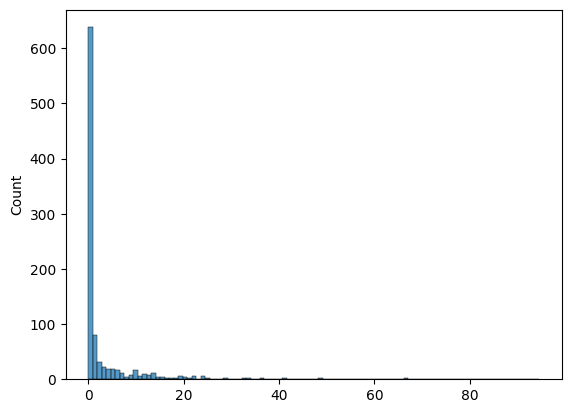

In [160]:
rand_trg = np.random.choice(trgcodes)
print(f"The randomly selected TRGCODE is {rand_trg}")

sns.histplot(dataset.loc[dataset['TRGCODE'] == rand_trg].iloc[0, 4:980].values, bins=100)

## Creating Some Useful Data Containers

### Make `year_wise_dict`

In [161]:
years = list(range(2015, 2023))

year_wise_dict = {}

year_columns = {
    year: [col for col in dataset.columns if str(year) in str(col)]
    for year in years
}

col_positions = {col: i for i, col in enumerate(dataset.columns)}

## itertuples is faster than iterrows, but it cannot alter the accessed data
for row in dataset.itertuples(index=False):
    trgcode = row.TRGCODE

    year_wise_dict[trgcode] = {}

    for year in years:
        cols = year_columns[year]

        rainfall_vector = [row[col_positions[col]] for col in cols]
        year_wise_dict[trgcode][year] = np.array(rainfall_vector)

### Calculate `cos_sims`

In [162]:
cos_sim_dict = {}

for trgcode in trgcodes:

    vectors = [year_wise_dict[trgcode][year] for year in years]
    tensor_data = torch.tensor(vectors, dtype=torch.float32)

    norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
    sim_matrix = torch.mm(norm_data, norm_data.T)

    cos_sim_dict[trgcode] = sim_matrix

## Split

In [163]:
train_trgcodes, test_trgcodes = train_test_split(trgcodes, test_size=0.2, random_state=3707)

In [164]:
print(len(train_trgcodes))
print(len(test_trgcodes))

3145
787


## Calculate `all_cos_sims` (train only)

In [165]:
all_cos_sims = []

for trgcode in train_trgcodes:
    cos_sim = cos_sim_dict[trgcode]
    cos_sim_no_diag = cos_sim.clone()
    cos_sim_no_diag.fill_diagonal_(float('nan'))
    
    flat_sims = cos_sim_no_diag[~torch.isnan(cos_sim_no_diag)]
    all_cos_sims.append(flat_sims)

## This is the tensor that has all the cosine-similarity scores (exclusing self-similarites) for all TRGCODEs and YEARs
all_cos_sims = torch.cat(all_cos_sims)

## Calculate Threshold

In [166]:
global_percentile_dict = {}

for i in range(10, 100, 5):
    global_percentile_dict[i] = torch.quantile(all_cos_sims, i/100).item()

In [167]:
print(global_percentile_dict)

{10: 0.011002246290445328, 15: 0.023785404860973358, 20: 0.03559299558401108, 25: 0.04703690856695175, 30: 0.05820449814200401, 35: 0.06975299119949341, 40: 0.08150132745504379, 45: 0.09381289780139923, 50: 0.10744243860244751, 55: 0.1222638189792633, 60: 0.13817870616912842, 65: 0.15630164742469788, 70: 0.17646552622318268, 75: 0.20019467175006866, 80: 0.2290014922618866, 85: 0.2681051790714264, 90: 0.3198337256908417, 95: 0.39994749426841736}


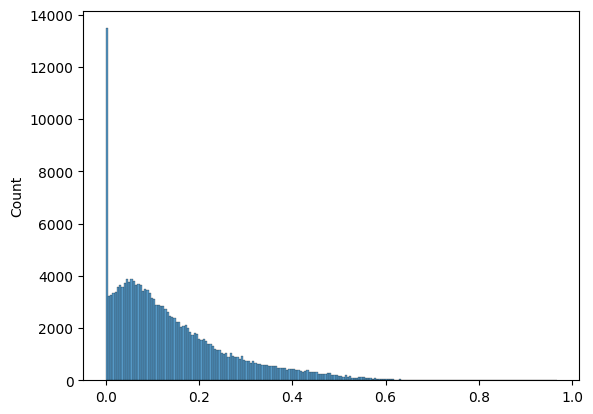

In [168]:
ax = sns.histplot(all_cos_sims.numpy(), bins=200, stat='count') 

## Generate Labels

In [169]:
threshold = global_percentile_dict[75]
stable_rain = []
unstable_rain = []
trg_means = []

for trgcode in trgcodes: ## Labels for all graphs are generated using threshold computed on training set
    sim_matrix = cos_sim_dict[trgcode]
    trg_mean = (sim_matrix.sum() - sim_matrix.trace()) / (64 - 8)
    trg_means.append(trg_mean.item())

    if (trg_mean >= threshold):
        stable_rain.append(trgcode)
    else:
        unstable_rain.append(trgcode)

<Axes: ylabel='Count'>

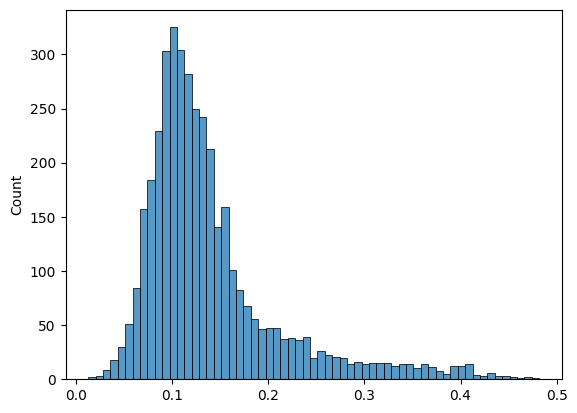

In [170]:
sns.histplot(trg_means)

In [171]:
print(len(stable_rain))
print(len(unstable_rain))

579
3353


In [172]:
stable_dataset = dataset[dataset['TRGCODE'].isin(stable_rain)]
unstable_dataset = dataset[dataset['TRGCODE'].isin(unstable_rain)]

In [173]:
print(len(stable_rain))
print(len(unstable_rain))

579
3353


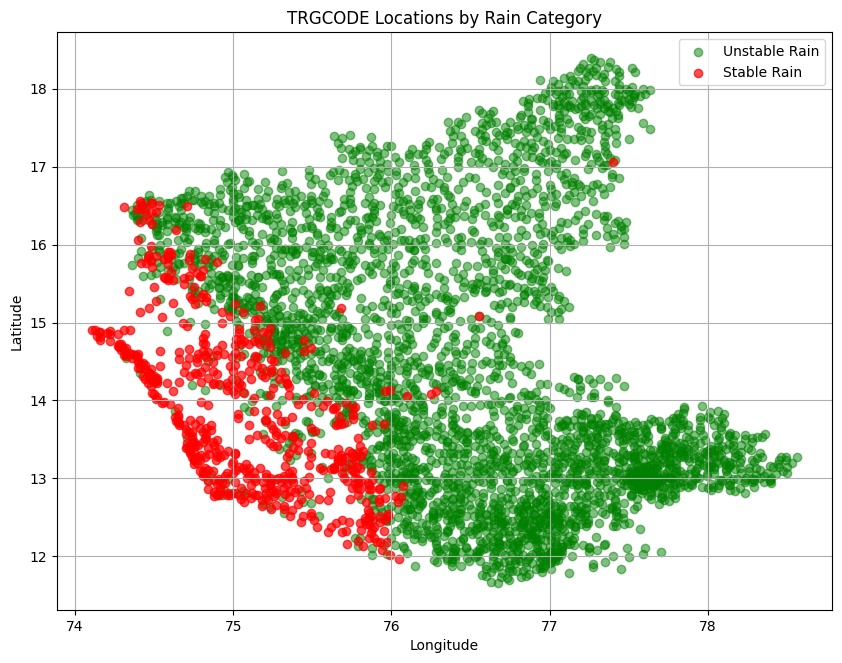

In [174]:
plt.figure(figsize=(10, 7.5))

plt.scatter(unstable_dataset['LONGITUDE'], unstable_dataset['LATITUDE'], color='green', label='Unstable Rain', alpha=0.5)
plt.scatter(stable_dataset['LONGITUDE'], stable_dataset['LATITUDE'], color='red', label='Stable Rain', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('TRGCODE Locations by Rain Category')
plt.legend()
plt.grid()
plt.show()

In [175]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

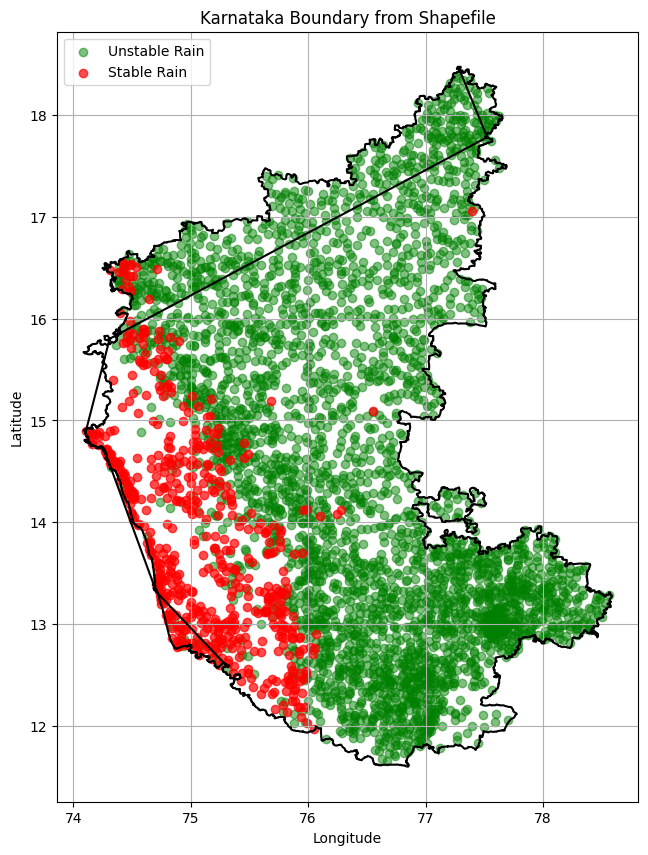

In [176]:
plt.figure(figsize=(7.5, 10))
for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

plt.scatter(unstable_dataset['LONGITUDE'], unstable_dataset['LATITUDE'], color='green', label='Unstable Rain', alpha=0.5)
plt.scatter(stable_dataset['LONGITUDE'], stable_dataset['LATITUDE'], color='red', label='Stable Rain', alpha=0.7)

plt.title("Karnataka Boundary from Shapefile")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [177]:
karnataka_lon_lat = np.array(lon_lat)

# Generating the Graphs

In [178]:
for trgcode in trgcodes: ## Mean for all graphs can be computed together
    sum = np.zeros(np.shape(year_wise_dict[trgcode][2022]))

    for year in years:
        sum += year_wise_dict[trgcode][year]

    year_wise_dict[trgcode]['MEAN'] = sum / len(years)

## Training Graph Generation

In [179]:
train_graphs = {}

for trgcode in train_trgcodes:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = cos_sim_dict[trgcode][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [year_wise_dict[trgcode]['MEAN']]

    for year in years:
        node_features.append(year_wise_dict[trgcode][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    if (trgcode in stable_rain):
        label = torch.tensor([1])
    else: 
        label = torch.tensor([0])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    train_graphs[trgcode] = graph

The randomly selected TRGCODE is 2575


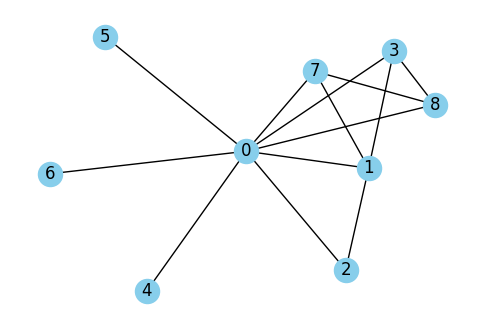

In [180]:
rand_trg = np.random.choice(train_trgcodes)
print(f"The randomly selected TRGCODE is {rand_trg}")

G = to_networkx(train_graphs[rand_trg], to_undirected=True)

fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

In [181]:
print(rand_trg in stable_rain)

False


## Testing Graph Generation

In [182]:
test_graphs = {}

for trgcode in test_trgcodes:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = cos_sim_dict[trgcode][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [year_wise_dict[trgcode]['MEAN']]

    for year in years:
        node_features.append(year_wise_dict[trgcode][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    if (trgcode in stable_rain):
        label = torch.tensor([1])
    else: 
        label = torch.tensor([0])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    test_graphs[trgcode] = graph

The randomly selected TRGCODE is 2645


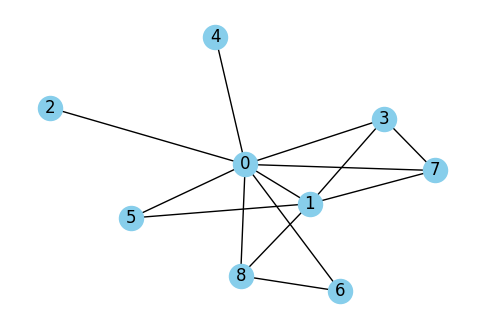

In [183]:
rand_trg = np.random.choice(test_trgcodes)
print(f"The randomly selected TRGCODE is {rand_trg}")

G = to_networkx(test_graphs[rand_trg], to_undirected=True)

fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

In [184]:
print(rand_trg in stable_rain)

False


# Training the Model

In [185]:
stratify_labels = [graph.y.item() for graph in train_graphs.values()]

In [186]:
print(len(train_graphs))
print(len(test_graphs))

3145
787


In [187]:
train_loader = DataLoader(list(train_graphs.values()), batch_size=128, shuffle=True)
test_loader = DataLoader(list(test_graphs.values()), batch_size=32, shuffle=True)

In [188]:
stable = 0
unstable = 0

for trgcode in train_trgcodes:
    if trgcode in stable_rain:
        stable += 1
    else:
        unstable += 1

print(f'Number of stable locations in training set: {stable}')
print(f'Number of unstable locations in training set: {unstable}')
print(f'Percentage of stable in training set: {stable / (stable + unstable) * 100:.4f}')

Number of stable locations in training set: 466
Number of unstable locations in training set: 2679
Percentage of stable in training set: 14.8172


In [189]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=[g.y.item() for g in train_graphs.values()]
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights_tensor)

tensor([0.5870, 3.3745])


In [190]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(3707)
        self.conv1 = GCNConv(122, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels) ## Same size to refine node embeddings
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        ## STEP 1: To obtain node embeddings
        x = self.conv1(x, edge_index) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)

        ## STEP 2: Readout layer
        x = global_max_pool(x, batch) ## Computes batch wise mean of the graphs that have been batched. Returns one feature vector per batch

        ## STEP 3: Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training) ## Dropout is regularization to prevent overfitting
        x = self.lin(x)

        return x

In [191]:
model = GCN(hidden_channels=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    verbose=True
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor) 

def train(train_loader):
    model.train() ## Toggles training mode. Enables dropout, updates running statistics, etc. READ MORE.

    total_loss = 0

    for train_graph in train_loader:
        out = model(train_graph.x.float(), train_graph.edge_index, train_graph.batch) ## A single forward pass
        loss = criterion(out, train_graph.y.long()) ## Compute cross entropy loss
        loss.backward() ## Find the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() ## Update parameters based on gradients
        optimizer.zero_grad() ## Clear gradients
        total_loss += loss.item() * train_graph.num_graphs
    
    return total_loss / len(train_loader.dataset)

def test(test_loader):
    model.eval() ## Toggles testing behaviour. READ MORE.

    correct = 0

    for graph in test_loader:
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        prediction = out.argmax(dim=1) ## Use the class with highest probability
        correct += int((prediction == graph.y).sum())
    
    return correct / len(test_loader.dataset)

/home/prad/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [192]:
losses = list()
train_accuracies = list()
test_accuracies = list()

best_test_accuracy = 0
patience_counter = 0
patience = 10

for epoch in range(1, 120):
    loss = train(train_loader)
    losses.append(loss)
    train_accuracy = test(train_loader)
    test_accuracy = test(test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Patience Counter: {patience_counter}')

    scheduler.step(test_accuracy)

    if (test_accuracy > best_test_accuracy):
        best_test_accuracy = test_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("----- Early stopping triggered -----")
        break

Epoch: 001, Train Accuracy: 0.9107, Test Accuracy: 0.9187, Patience Counter: 0
Epoch: 002, Train Accuracy: 0.9456, Test Accuracy: 0.9441, Patience Counter: 0
Epoch: 003, Train Accuracy: 0.9561, Test Accuracy: 0.9517, Patience Counter: 0
Epoch: 004, Train Accuracy: 0.9469, Test Accuracy: 0.9466, Patience Counter: 0
Epoch: 005, Train Accuracy: 0.9539, Test Accuracy: 0.9530, Patience Counter: 1
Epoch: 006, Train Accuracy: 0.9459, Test Accuracy: 0.9492, Patience Counter: 0
Epoch: 007, Train Accuracy: 0.9405, Test Accuracy: 0.9327, Patience Counter: 1
Epoch: 008, Train Accuracy: 0.9370, Test Accuracy: 0.9352, Patience Counter: 2
Epoch: 009, Train Accuracy: 0.9520, Test Accuracy: 0.9543, Patience Counter: 3
Epoch: 010, Train Accuracy: 0.9596, Test Accuracy: 0.9619, Patience Counter: 0
Epoch: 011, Train Accuracy: 0.9488, Test Accuracy: 0.9416, Patience Counter: 0
Epoch: 012, Train Accuracy: 0.9568, Test Accuracy: 0.9466, Patience Counter: 1
Epoch: 013, Train Accuracy: 0.9472, Test Accuracy: 0

In [193]:
# torch.save(model.state_dict(), 'model_log_bias.pth')
torch.save(model.state_dict(), 'model_vanilla.pth')

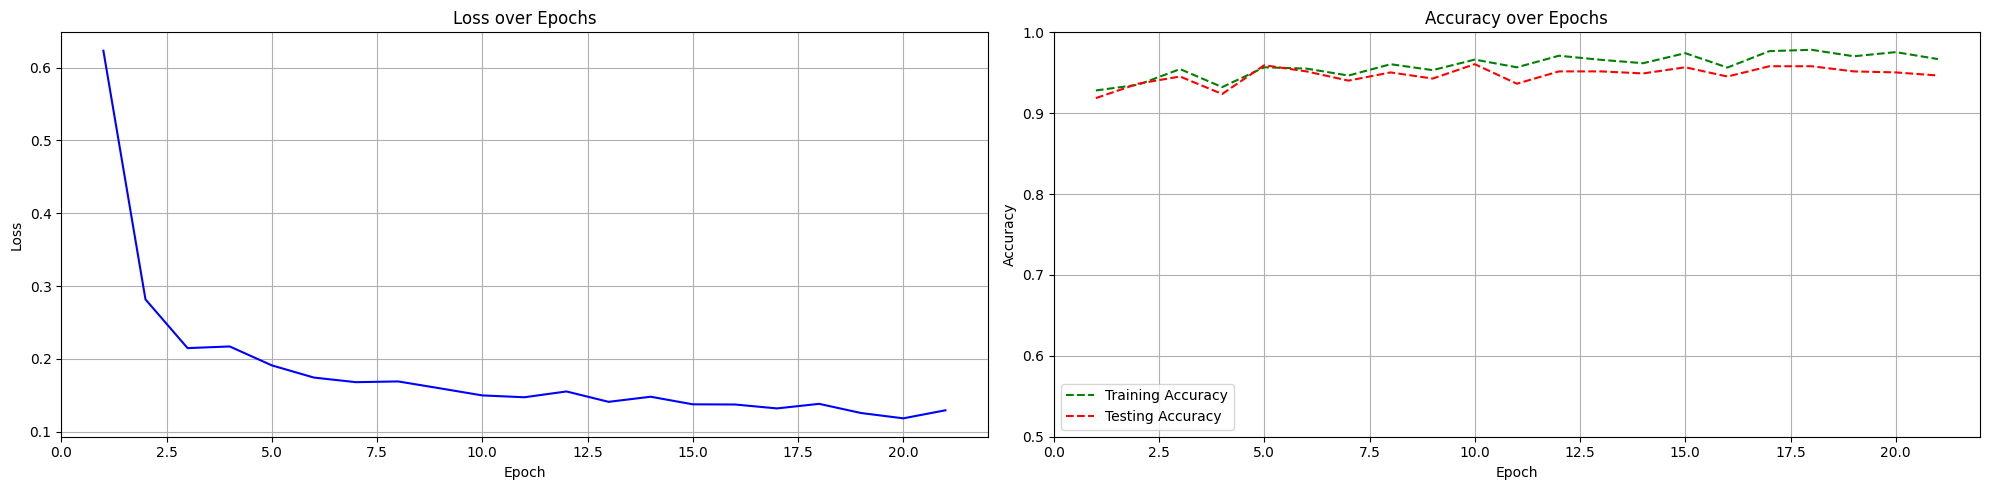

In [121]:
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(20, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b-')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g--', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r--', label='Testing Accuracy')
plt.legend()
plt.ylim(0.5, 1)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing the Model

In [122]:
model.eval()

test_y_pred = list()

for graph in test_graphs.values():
    
    with torch.no_grad():
        num_nodes = graph.x.size(0)
        batch = torch.zeros(num_nodes, dtype=torch.long)
        out = model(graph.x.float(), graph.edge_index, batch)
        prediction = out.argmax(dim=1).item()

    test_y_pred.append(prediction)

print(len(test_y_pred))

787


In [123]:
test_y_true = list()

for trgcode in test_graphs.keys():
    test_y_true.append(int(trgcode in stable_rain))

print(len(test_y_true))

787


Confusion Matrix:
[[619  28]
 [ 14 126]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.98      0.96      0.97       647
      Stable       0.82      0.90      0.86       140

    accuracy                           0.95       787
   macro avg       0.90      0.93      0.91       787
weighted avg       0.95      0.95      0.95       787



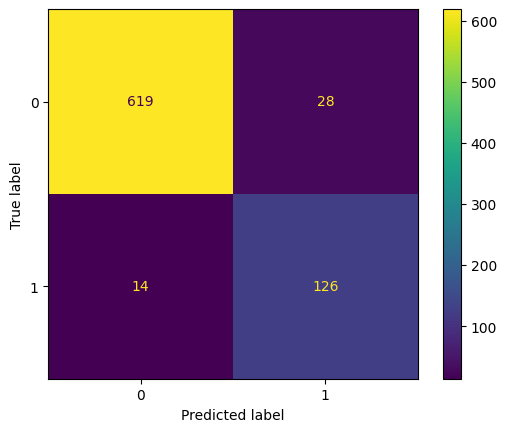

In [124]:
test_confu_mat = confusion_matrix(test_y_true, test_y_pred)
print('Confusion Matrix:')
print(test_confu_mat)

ConfusionMatrixDisplay(test_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(test_y_true, test_y_pred, target_names=['Unstable', 'Stable']))

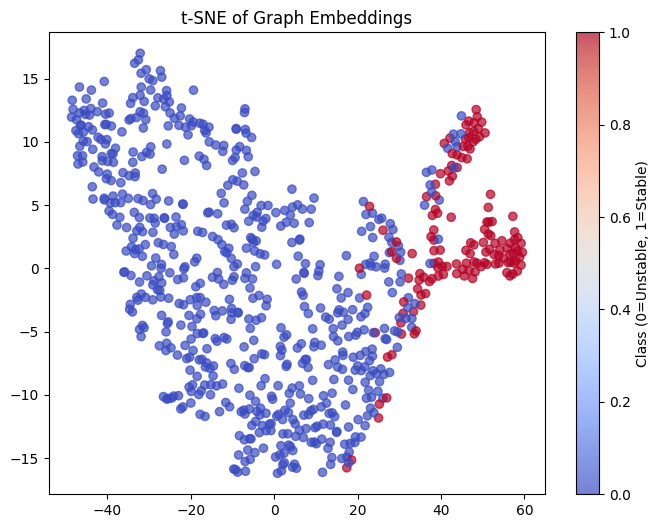

In [125]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for graph in test_graphs.values():
        x = graph.x.float()
        edge_index = graph.edge_index
        batch = torch.zeros(x.size(0), dtype=torch.long)
        out = model.conv1(x, edge_index)
        out = out.relu()
        out = model.conv2(out, edge_index)
        graph_embed = global_max_pool(out, batch)
        
        embeddings.append(graph_embed.cpu().numpy())
        labels.append(graph.y.item())

# Reduce to 2D
embeddings_2d = TSNE(n_components=2).fit_transform(np.vstack(embeddings))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of Graph Embeddings")
plt.colorbar(label="Class (0=Unstable, 1=Stable)")
plt.show()

### Inferences from t-SNE (ChatGPT)

**GOAL**

t-SNE tries to reduce the dimensionality (e.g., from 64D → 2D), while:

Preserving local structure: Points that were close in high dimensions should stay close in 2D.

Allowing global distortion: t-SNE doesn't care about big-picture layout; it emphasizes cluster separation and tightness.

**CORE IDEA**

t-SNE builds a "probability" that point A is near point B in high-dimensional space.

Then it builds a similar probability in 2D space.

It adjusts the 2D positions so that the two probability maps are as close as possible.

So: Clusters in t-SNE imply meaningful similarity, but distances between clusters may not be.

**INFERENCES**

1. Clear separation of stable graphs
The red points are clustered tightly in the right side.

This implies your model is generating similar embeddings for all stable cities.

So: Stable graphs are easily learnable / internally consistent → great news.

2. Unstable graphs are more spread out
Blue points are scattered all over the left (and even middle).

Suggests unstable graphs have greater variability in features.

t-SNE sees them as more different from one another, and even sometimes close to stable (blue-red boundaries).

This matches intuition: "unstable" can manifest in many ways.

3. A distinct boundary forms
There’s a fairly clean boundary between stable and unstable regions.

This means your model has likely learned a good latent space, where the decision boundary is meaningful.

A linear classifier on top of this embedding would likely do well — which matches your ~80% test accuracy.

# Rainfall Magnitude Analysis

For this section, I will try to classify rainfall based on the following image.

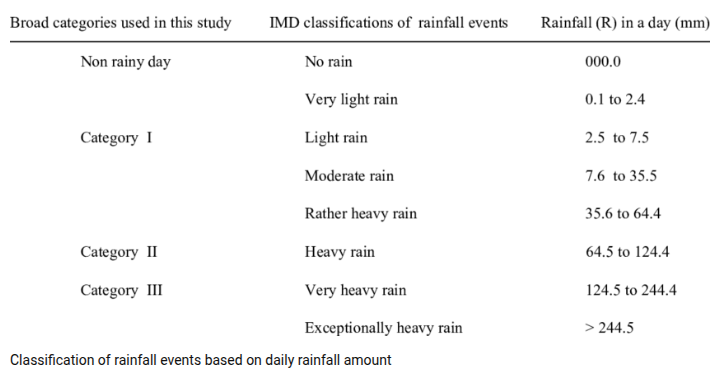

I will classify as (all values are in mm/day):-

- Very Light Rain: 0 - 2.4
- Light Rain: 2.5 - 7.5
- Moderate Rain: 7.6 - 35.5
- Rather Heavy Rain: 35.6 - 64.4
- Heavy Rain: 64.5 - 124.4
- Very Heavy Rain: 124.5 +

In [ ]:
def get_avg_rainfall(trgcode):
    
    sum = 0

    for year in years:
        for day in year_wise_dict[trgcode][year]:
            rain = np.expm1(day) - bias
            sum += rain

    avg_rainfall = sum / (122 * 8)

    return avg_rainfall

In [51]:
rainfall = {
    'very_light': [],
    'light': [],
    'moderate': [],
    'rather_heavy': [],
    'heavy': [],
    'very_heavy': []
}

for trgcode in trgcodes:
    avg_rainfall = get_avg_rainfall(trgcode)

    if (avg_rainfall <= 2.4):
        rainfall['very_light'].append(trgcode)
    elif (avg_rainfall <= 7.5):
        rainfall['light'].append(trgcode)
    elif (avg_rainfall <= 35.5):
        rainfall['moderate'].append(trgcode)
    elif (avg_rainfall <= 64.4):
        rainfall['rather_heavy'].append(trgcode)
    elif (avg_rainfall <= 124.4):
        rainfall['heavy'].append(trgcode)
    else:
        rainfall['very_heavy'].append(trgcode)

In [ ]:
for key in rainfall.keys():
    print(f"Number of {key} rainfall areas: {len(rainfall[key])}")

Number of very_light rainfall areas: 1703
Number of light rainfall areas: 1803
Number of moderate rainfall areas: 426
Number of rather_heavy rainfall areas: 0
Number of heavy rainfall areas: 0
Number of very_heavy rainfall areas: 0


In [53]:
for key in rainfall.keys():
    sum = 0

    for trgcode in rainfall[key]:
        if trgcode in test_trgcodes:
            sum += 1

    print(f"Number of {key} rainfall areas in testing set: {sum}")

Number of very_light rainfall areas in testing set: 349
Number of light rainfall areas in testing set: 352
Number of moderate rainfall areas in testing set: 86
Number of rather_heavy rainfall areas in testing set: 0
Number of heavy rainfall areas in testing set: 0
Number of very_heavy rainfall areas in testing set: 0


## Very Light

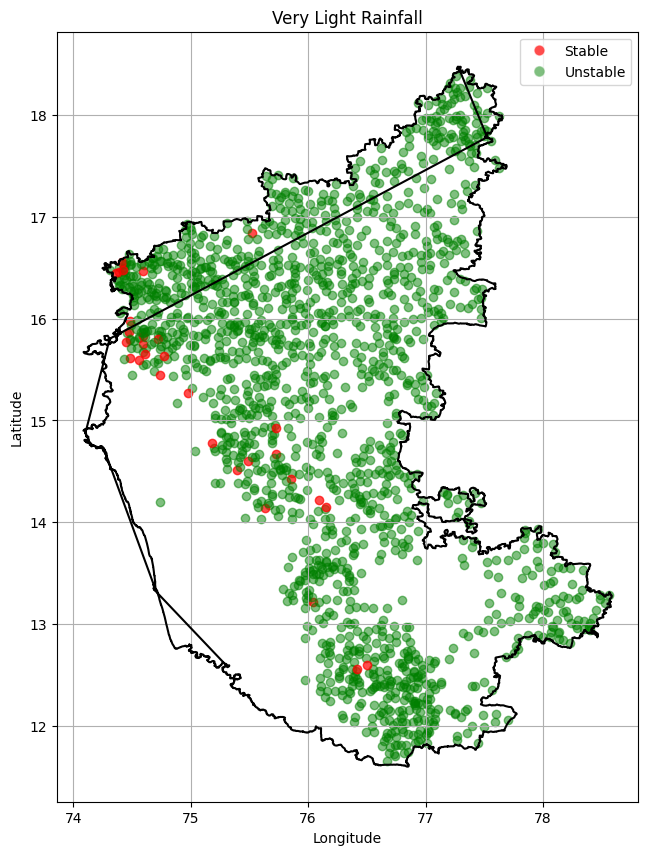

In [54]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

plt.figure(figsize=(7.5, 10))

for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

for trgcode in rainfall['very_light']:

    if trgcode in stable_rain:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LONGITUDE'],
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

plt.title("Very Light Rainfall")
plt.legend(handles=legend_elements)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [55]:
model.eval()

very_light_y_pred = list()

for trgcode in rainfall['very_light']:
    if trgcode in test_trgcodes:
        graph = test_graphs[trgcode]
        
        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        very_light_y_pred.append(prediction)

very_light_y_true = list()

for trgcode in rainfall['very_light']:
    if trgcode in test_trgcodes:
        very_light_y_true.append(int(trgcode in stable_rain))

print(len(very_light_y_pred))
print(len(very_light_y_true))

349
349


Confusion Matrix:
[[339   4]
 [  3   3]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.99      0.99      0.99       343
      Stable       0.43      0.50      0.46         6

    accuracy                           0.98       349
   macro avg       0.71      0.74      0.73       349
weighted avg       0.98      0.98      0.98       349



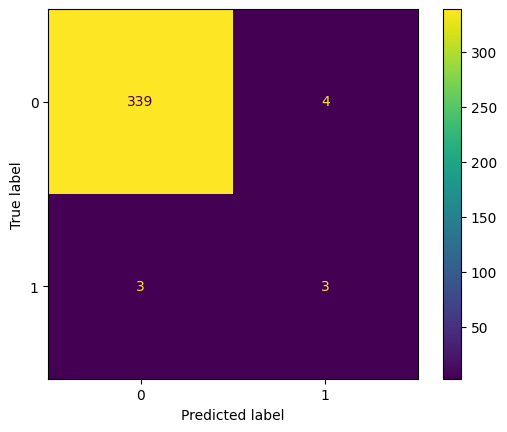

In [56]:
very_light_confu_mat = confusion_matrix(very_light_y_true, very_light_y_pred)
print('Confusion Matrix:')
print(very_light_confu_mat)

ConfusionMatrixDisplay(very_light_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(very_light_y_true, very_light_y_pred, target_names=['Unstable', 'Stable']))

## Light

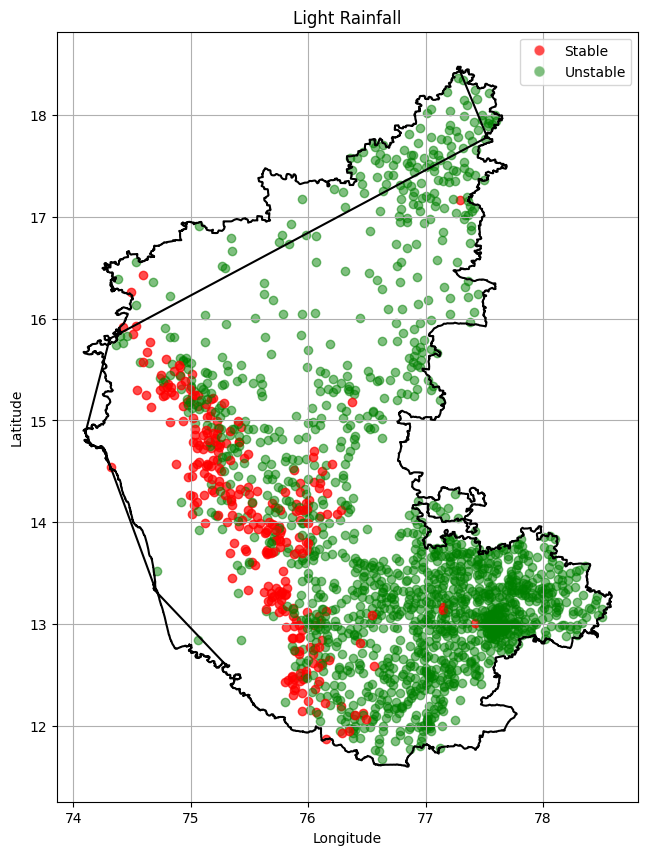

In [57]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

plt.figure(figsize=(7.5, 10))

for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

for trgcode in rainfall['light']:

    if trgcode in stable_rain:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LONGITUDE'],
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

plt.title("Light Rainfall")
plt.legend(handles=legend_elements)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [58]:
model.eval()

light_y_pred = list()

for trgcode in rainfall['light']:
    if trgcode in test_trgcodes:
        graph = test_graphs[trgcode]
        
        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        light_y_pred.append(prediction)

light_y_true = list()

for trgcode in rainfall['light']:
    if trgcode in test_trgcodes:
        light_y_true.append(trgcode in stable_rain)

print(len(light_y_pred))
print(len(light_y_true))

352
352


Confusion Matrix:
[[279  19]
 [ 10  44]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.97      0.94      0.95       298
      Stable       0.70      0.81      0.75        54

    accuracy                           0.92       352
   macro avg       0.83      0.88      0.85       352
weighted avg       0.92      0.92      0.92       352



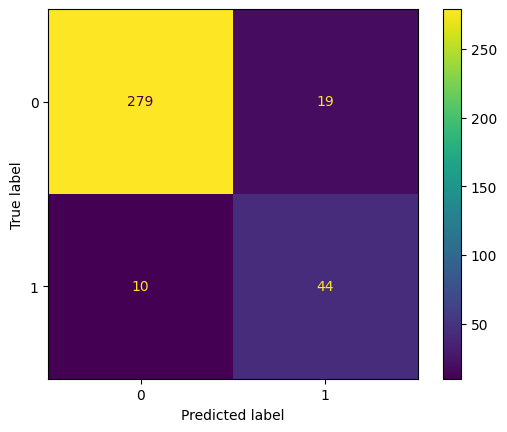

In [59]:
light_confu_mat = confusion_matrix(light_y_true, light_y_pred)
print('Confusion Matrix:')
print(light_confu_mat)

ConfusionMatrixDisplay(light_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(light_y_true, light_y_pred, target_names=['Unstable', 'Stable']))

## Moderate                                         

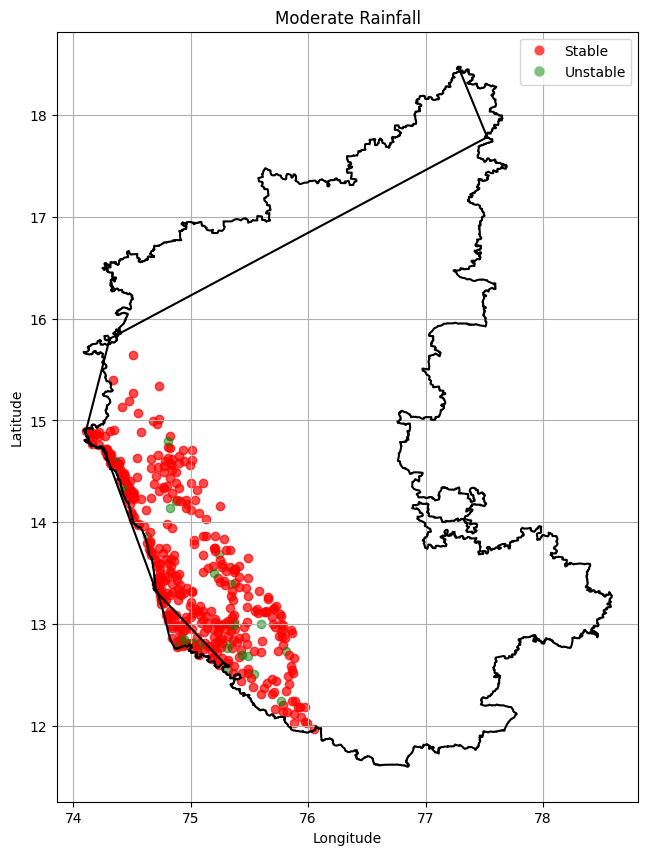

In [60]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

plt.figure(figsize=(7.5, 10))

for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

for trgcode in rainfall['moderate']:

    if trgcode in stable_rain:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LONGITUDE'],
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

plt.title("Moderate Rainfall")
plt.legend(handles=legend_elements)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [ ]:
model.eval()

moderate_y_pred = list()

for trgcode in rainfall['moderate']:
    if trgcode in test_trgcodes:
        graph = test_graphs[trgcode]
        
        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        moderate_y_pred.append(prediction)

moderate_y_true = list()

for trgcode in rainfall['moderate']:
    if trgcode in test_trgcodes:
        moderate_y_true.append(trgcode in stable_rain)

print(len(moderate_y_pred))
print(len(moderate_y_true))

86
86


Confusion Matrix:
[[ 1  5]
 [ 1 79]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.50      0.17      0.25         6
      Stable       0.94      0.99      0.96        80

    accuracy                           0.93        86
   macro avg       0.72      0.58      0.61        86
weighted avg       0.91      0.93      0.91        86



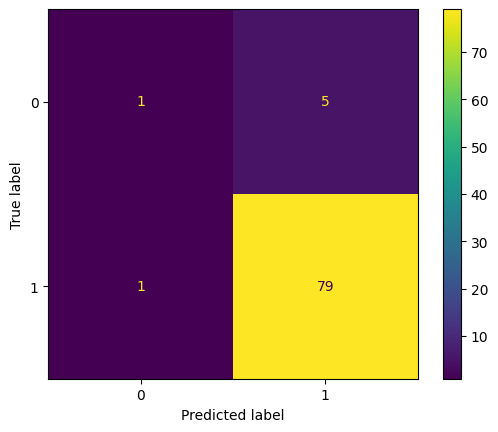

In [62]:
moderate_confu_mat = confusion_matrix(moderate_y_true, moderate_y_pred)
print('Confusion Matrix:')
print(moderate_confu_mat)

ConfusionMatrixDisplay(moderate_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(moderate_y_true, moderate_y_pred, target_names=['Unstable', 'Stable']))

In [63]:
print('\nClassification Report (Test):')
print(classification_report(test_y_true, test_y_pred, target_names=['Unstable', 'Stable']))

print('\nClassification Report (Very Light):')
print(classification_report(very_light_y_true, very_light_y_pred, target_names=['Unstable', 'Stable']))

print('\nClassification Report (Light):')
print(classification_report(light_y_true, light_y_pred, target_names=['Unstable', 'Stable']))

print('\nClassification Report (Moderate):')
print(classification_report(moderate_y_true, moderate_y_pred, target_names=['Unstable', 'Stable']))


Classification Report (Test):
              precision    recall  f1-score   support

    Unstable       0.98      0.96      0.97       647
      Stable       0.82      0.90      0.86       140

    accuracy                           0.95       787
   macro avg       0.90      0.93      0.91       787
weighted avg       0.95      0.95      0.95       787


Classification Report (Very Light):
              precision    recall  f1-score   support

    Unstable       0.99      0.99      0.99       343
      Stable       0.43      0.50      0.46         6

    accuracy                           0.98       349
   macro avg       0.71      0.74      0.73       349
weighted avg       0.98      0.98      0.98       349


Classification Report (Light):
              precision    recall  f1-score   support

    Unstable       0.97      0.94      0.95       298
      Stable       0.70      0.81      0.75        54

    accuracy                           0.92       352
   macro avg       0.83     

# Comparing with GSMap Data

## Extracting Data

In [64]:
min_lat = karnataka_lon_lat[:,1].min()
max_lat = karnataka_lon_lat[:,1].max()
min_lon = karnataka_lon_lat[:,0].min()
max_lon = karnataka_lon_lat[:,0].max()

print(f"Latitude Min: {min_lat:.2f}, Latitude Max: {max_lat:.2f}")
print(f"Longitude Min: {min_lon:.2f}, Longitude Max: {max_lon:.2f}")

Latitude Min: 11.59, Latitude Max: 18.48
Longitude Min: 74.09, Longitude Max: 78.59


In [ ]:
def align_to_grid(min_val, max_val, step=0.1, offset=0.05):
    min_grid = offset + math.floor((min_val - offset) / step) * step
    max_grid = offset + math.ceil((max_val - offset) / step) * step
    return min_grid, max_grid

In [66]:
grid_lat_min, grid_lat_max = align_to_grid(min_lat, max_lat)
grid_lon_min, grid_lon_max = align_to_grid(min_lon, max_lon)

print(f"Latitude Gridpoint Min: {grid_lat_min:.2f}, Latitude Gridpoint Max: {grid_lat_max:.2f}")
print(f"Longitude Gridpoint Min: {grid_lon_min:.2f}, Longitude Gridpoint Max: {grid_lon_max:.2f}")

Latitude Gridpoint Min: 11.55, Latitude Gridpoint Max: 18.55
Longitude Gridpoint Min: 74.05, Longitude Gridpoint Max: 78.65


### On a small 2x2 grid to verify

In [67]:
# args = [
#     "python3", "hdf5_to_grid_csv.py"
# ]

# subprocess.run(args)

In [68]:
# test_grid = pd.read_csv('grid_timeseries_test.csv')

In [69]:
# test_grid

### For Karnataka

In [70]:
output_fname = "/home/prad/code/precipitation_gauge_gnn/karnataka_grid_timeseries.csv"

In [71]:
# args = [
#     "python3", "hdf5_to_grid_csv.py",
#     "--lat_min", f"{grid_lat_min}",
#     "--lat_max", f"{grid_lat_max}",
#     "--lon_min", f"{grid_lon_min}",
#     "--lon_max", f"{grid_lon_max}",
#     "--output_csv", f"{output_fname}"
# ]

# subprocess.run(args)

In [72]:
raw_karnataka_dataset = pd.read_csv('karnataka_grid_timeseries.csv')

In [73]:
raw_karnataka_dataset

,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,74.05,11.55,70090,0.0,0.287486,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.056948,0.0,0.0,0.0
1,74.05,11.65,70090,0.0,0.269300,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.047744,0.0,0.0,0.0
2,74.05,11.75,70090,0.0,0.301475,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,74.05,11.85,70090,0.0,0.196299,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,74.05,11.95,70090,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,78.65,18.15,70090,0.0,0.325378,22.455250,3.849364,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3333,78.65,18.25,70090,0.0,1.788692,24.050983,4.262405,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3334,78.65,18.35,70090,0.0,2.969586,24.387045,4.401913,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3335,78.65,18.45,70090,0.0,5.375727,24.489685,4.411944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


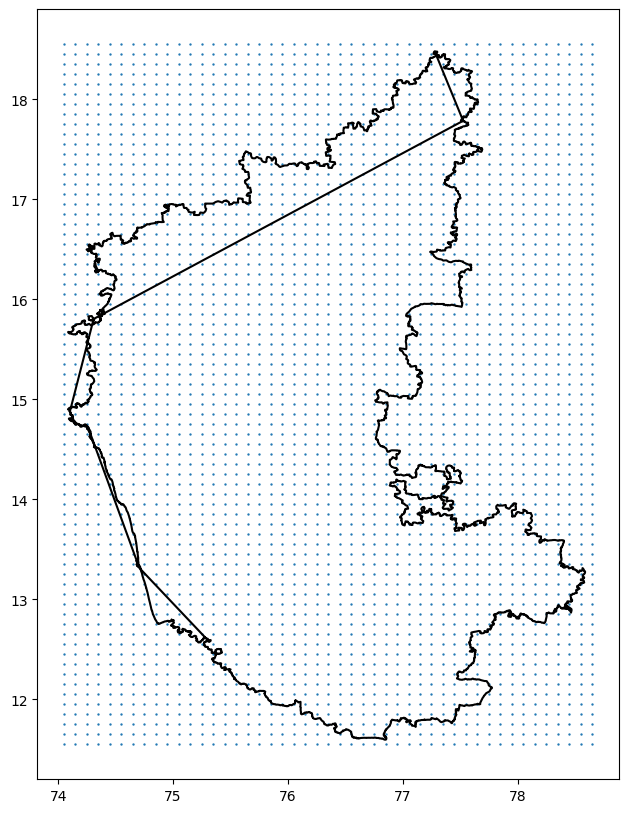

In [74]:
## To verify that the grid is loaded correctly
plt.figure(figsize=(7.5, 10))
for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

plt.scatter(raw_karnataka_dataset['LONGITUDE'], raw_karnataka_dataset['LATITUDE'], s=0.5)

In [136]:
raw_karnataka_dataset.columns

Index(['LONGITUDE', 'LATITUDE', 'VALID_POINTS', '2015-01-01', '2015-01-02',
       '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07',
       ...
       '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
      dtype='object', length=2925)

In [137]:
raw_karnataka_dataset.columns[3]

'2015-01-01'

In [138]:
meta_data = raw_karnataka_dataset.iloc[:, :3]
date_data = raw_karnataka_dataset.iloc[:, 3:]
print(meta_data.shape)
print(date_data.shape)

(3337, 3)
(3337, 2922)


In [139]:
date_data.columns = pd.to_datetime(date_data.columns)

In [140]:
mask = date_data.columns.map(
    lambda d: (d.month > 5 and d.month < 10)
)

In [141]:
karnataka_dataset_not_pre = date_data.loc[:, mask]
karnataka_dataset_not_pre.columns = karnataka_dataset_not_pre.columns.strftime('%Y-%m-%d')

In [142]:
loc_id = pd.Series([i for i in range(meta_data.shape[0])], name='LOC_ID')

meta_data = pd.concat([loc_id.reset_index(drop=True), meta_data.reset_index(drop=True)], axis=1)

karnataka_dataset_not_pre = pd.concat([meta_data, karnataka_dataset_not_pre], axis=1)

In [143]:
karnataka_dataset_not_pre

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,74.05,11.55,70090,1.280954,0.079308,3.967222,32.774185,0.827167,6.825593,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.592231
1,1,74.05,11.65,70090,1.145191,0.445717,6.743265,30.673952,0.908627,3.723992,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.395695
2,2,74.05,11.75,70090,0.591019,0.763167,9.621930,29.946466,1.280922,1.230831,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.422275
3,3,74.05,11.85,70090,0.000000,1.461665,7.120384,32.693462,2.625886,1.861328,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.499051
4,4,74.05,11.95,70090,0.000000,0.932015,5.177581,34.063496,4.559991,2.174394,...,0.000000,0.000000,0.014793,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.025963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,3332,78.65,18.15,70090,0.873916,8.688861,0.000000,3.845152,0.150311,1.967779,...,10.950179,2.793023,0.000000,0.0,0.0,2.216781,0.0,6.281692,4.701965,0.000000
3333,3333,78.65,18.25,70090,1.208413,9.457102,0.000000,3.674678,0.155699,1.433062,...,11.577258,2.978141,0.000000,0.0,0.0,2.114422,0.0,4.689294,2.724058,0.000000
3334,3334,78.65,18.35,70090,1.521100,8.647934,0.000000,3.218774,0.136055,1.334297,...,10.190564,2.480615,0.000000,0.0,0.0,3.263117,0.0,3.454654,1.452241,0.000000
3335,3335,78.65,18.45,70090,2.050546,6.312897,0.000000,2.340701,0.108734,0.920564,...,6.973896,1.481436,0.000000,0.0,0.0,7.072689,0.0,2.507486,0.741378,0.000000


In [144]:
bias = 1e-2

meta_columns = ['LOC_ID', 'LATITUDE', 'LONGITUDE', 'VALID_POINTS']

karnataka_dataset = karnataka_dataset_not_pre.copy()

karnataka_dataset.loc[:, ~karnataka_dataset.columns.isin(meta_columns)] = np.log1p(karnataka_dataset_not_pre.loc[:, ~karnataka_dataset.columns.isin(meta_columns)] + bias)

In [145]:
karnataka_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,74.05,11.55,70090,0.828969,0.085543,1.604872,3.519993,0.608225,2.058677,...,0.009950,0.009950,0.009950,0.00995,0.00995,0.009950,0.00995,0.009950,0.009950,0.471397
1,1,74.05,11.65,70090,0.767879,0.375499,2.048114,3.455810,0.651610,1.554769,...,0.009950,0.009950,0.009950,0.00995,0.00995,0.009950,0.00995,0.009950,0.009950,0.877839
2,2,74.05,11.75,70090,0.470640,0.572767,2.363862,3.432582,0.828954,0.806847,...,0.009950,0.009950,0.009950,0.00995,0.00995,0.009950,0.00995,0.009950,0.009950,0.888827
3,3,74.05,11.85,70090,0.009950,0.904892,2.095608,3.517601,1.290853,1.054775,...,0.009950,0.009950,0.009950,0.00995,0.00995,0.009950,0.00995,0.009950,0.009950,0.919905
4,4,74.05,11.95,70090,0.009950,0.663726,1.822544,3.557446,1.717393,1.158262,...,0.009950,0.009950,0.024491,0.00995,0.00995,0.009950,0.00995,0.009950,0.009950,1.110529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,3332,78.65,18.15,70090,0.633353,2.272008,0.009950,1.580040,0.148688,1.091178,...,2.481583,1.335796,0.009950,0.00995,0.00995,1.171485,0.00995,1.986736,1.742563,0.009950
3333,3333,78.65,18.25,70090,0.796792,2.348237,0.009950,1.544297,0.153321,0.893252,...,2.532685,1.383325,0.009950,0.00995,0.00995,1.139249,0.00995,1.740342,1.317496,0.009950
3334,3334,78.65,18.35,70090,0.928654,2.267780,0.009950,1.441912,0.136326,0.851985,...,2.415964,1.250078,0.009950,0.00995,0.00995,1.452343,0.00995,1.496192,0.901072,0.009950
3335,3335,78.65,18.45,70090,1.118593,1.991006,0.009950,1.209169,0.112197,0.657812,...,2.077427,0.912859,0.009950,0.00995,0.00995,2.089725,0.00995,1.257747,0.560403,0.009950


## Generating Graphs

In [146]:
loc_ids = karnataka_dataset['LOC_ID'].values
print(loc_ids)

[   0    1    2 ... 3334 3335 3336]


In [147]:
years = list(range(2015, 2023))

karnataka_year_wise_dict = {}

year_columns = {
    year: [col for col in karnataka_dataset.columns if str(year) in str(col)]
    for year in years
}

col_positions = {col: i for i, col in enumerate(karnataka_dataset.columns)}

## itertuples is faster than iterrows, but it cannot alter the accessed data
for row in karnataka_dataset.itertuples(index=False):
    loc_id = row.LOC_ID

    karnataka_year_wise_dict[loc_id] = {}

    for year in years:
        cols = year_columns[year]

        rainfall_vector = [row[col_positions[col]] for col in cols]
        karnataka_year_wise_dict[loc_id][year] = np.array(rainfall_vector)

In [148]:
karnataka_cos_sim_dict = {}

for loc_id in loc_ids:

    vectors = [karnataka_year_wise_dict[loc_id][year] for year in years]
    tensor_data = torch.tensor(vectors, dtype=torch.float32)

    norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
    sim_matrix = torch.mm(norm_data, norm_data.T)

    karnataka_cos_sim_dict[loc_id] = sim_matrix

In [149]:
for loc_id in loc_ids: ## Mean for all graphs can be computed together
    sum = np.zeros(np.shape(karnataka_year_wise_dict[loc_id][2022]))

    for year in years:
        sum += karnataka_year_wise_dict[loc_id][year]

    karnataka_year_wise_dict[loc_id]['MEAN'] = sum / len(years)

In [150]:
karnataka_graphs = {}

for loc_id in loc_ids:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = karnataka_cos_sim_dict[loc_id][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [karnataka_year_wise_dict[loc_id]['MEAN']]

    for year in years:
        node_features.append(karnataka_year_wise_dict[loc_id][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    label = torch.tensor([0.5])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    karnataka_graphs[loc_id] = graph

## Testing the Model

In [151]:
model.eval()

karnataka_test_y_pred = {}

for loc_id, graph in karnataka_graphs.items():
    
    with torch.no_grad():
        num_nodes = graph.x.size(0)
        batch = torch.zeros(num_nodes, dtype=torch.long)
        out = model(graph.x.float(), graph.edge_index, batch)
        prediction = out.argmax(dim=1).item()

    karnataka_test_y_pred[loc_id] = prediction

print(len(karnataka_test_y_pred))

3337


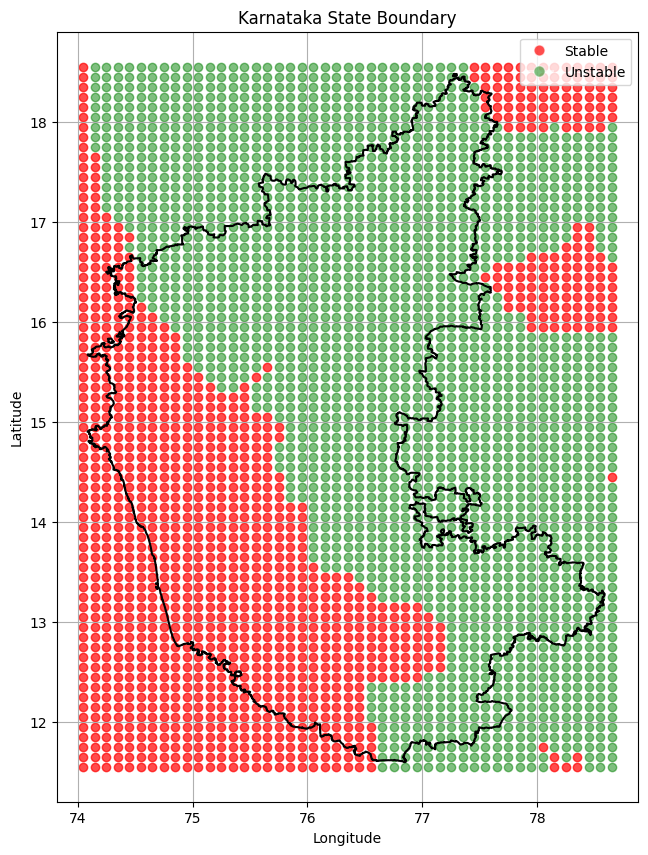

In [152]:
# Initialize shapefile reader
sf = shapefile.Reader("Karnataka/State.shp")

# UTM Zone 43N → WGS84 lat/lon
transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

fig, ax = plt.subplots(figsize=(7.5, 10))

for shape in sf.shapes():
    points = shape.points
    parts = list(shape.parts) + [len(points)]
    
    for i in range(len(parts) - 1):
        part_points = points[parts[i]:parts[i + 1]]
        x_proj, y_proj = zip(*part_points)
        lon, lat = transformer.transform(x_proj, y_proj)
        ax.plot(lon, lat, color='black')

for loc_id in loc_ids:

    if karnataka_test_y_pred[loc_id] == 1:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        karnataka_dataset.loc[karnataka_dataset['LOC_ID'] == loc_id, 'LONGITUDE'],
        karnataka_dataset.loc[karnataka_dataset['LOC_ID'] == loc_id, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Karnataka State Boundary")
plt.legend(handles=legend_elements)
plt.grid(True)
plt.show()

# Maharashtra

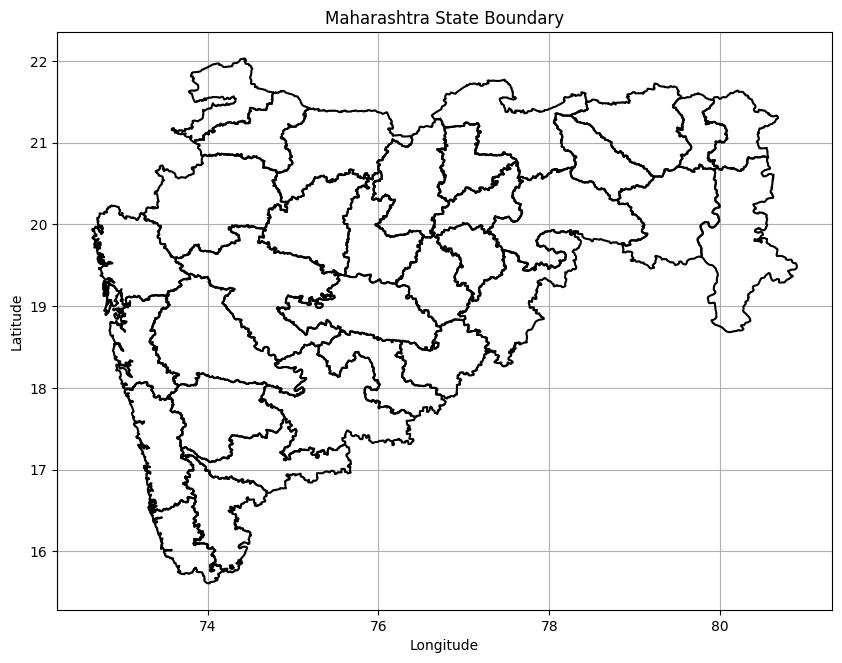

In [153]:
# Initialize shapefile reader
sf = shapefile.Reader("new_maha_district.shp")

fig, ax = plt.subplots(figsize=(10, 7.5))

# Loop through all shapes (district polygons)
for shape in sf.shapes():
    points = shape.points
    parts = list(shape.parts) + [len(points)]

    for i in range(len(parts) - 1):
        part_points = points[parts[i]:parts[i + 1]]
        lon, lat = zip(*part_points)
        ax.plot(lon, lat, color='black')

# --- Optional: Scatter points overlay (disabled) ---
# for loc_id in loc_ids:
#     if karnataka_test_y_pred[loc_id] == 1:
#         color = 'red'
#         alpha = 0.7
#     else:
#         color = 'green'
#         alpha = 0.5
#     plt.scatter(
#         karnataka_dataset.loc[karnataka_dataset['LOC_ID'] == loc_id, 'LONGITUDE'],
#         karnataka_dataset.loc[karnataka_dataset['LOC_ID'] == loc_id, 'LATITUDE'],
#         color=color,
#         alpha=alpha
#     )

# --- Optional: Legend (disabled) ---
# legend_elements = [
#     lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
#     lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
# ]

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Maharashtra State Boundary")
plt.grid(True)
# plt.legend(handles=legend_elements)
plt.show()

## Extracting Data

In [127]:
min_lat = 14
max_lat = 23
min_lon = 72
max_lon = 82

print(f"Latitude Min: {min_lat:.2f}, Latitude Max: {max_lat:.2f}")
print(f"Longitude Min: {min_lon:.2f}, Longitude Max: {max_lon:.2f}")

def align_to_grid(min_val, max_val, step=0.1, offset=0.05):
    min_grid = offset + math.floor((min_val - offset) / step) * step
    max_grid = offset + math.ceil((max_val - offset) / step) * step
    return min_grid, max_grid

grid_lat_min, grid_lat_max = align_to_grid(min_lat, max_lat)
grid_lon_min, grid_lon_max = align_to_grid(min_lon, max_lon)

print(f"Latitude Gridpoint Min: {grid_lat_min:.2f}, Latitude Gridpoint Max: {grid_lat_max:.2f}")
print(f"Longitude Gridpoint Min: {grid_lon_min:.2f}, Longitude Gridpoint Max: {grid_lon_max:.2f}")

Latitude Min: 14.00, Latitude Max: 23.00
Longitude Min: 72.00, Longitude Max: 82.00
Latitude Gridpoint Min: 13.95, Latitude Gridpoint Max: 23.05
Longitude Gridpoint Min: 71.95, Longitude Gridpoint Max: 82.05


In [128]:
output_fname = "/home/prad/code/precipitation_gauge_gnn/maharashtra_grid_timeseries.csv"

In [129]:
# args = [
#     "python3", "hdf5_to_grid_csv.py",
#     "--lat_min", f"{grid_lat_min}",
#     "--lat_max", f"{grid_lat_max}",
#     "--lon_min", f"{grid_lon_min}",
#     "--lon_max", f"{grid_lon_max}",
#     "--output_csv", f"{output_fname}"
# ]

# subprocess.run(args)

In [130]:
raw_mh_dataset = pd.read_csv('maharashtra_grid_timeseries.csv')

In [131]:
raw_mh_dataset

,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,71.95,14.05,70090,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,71.95,14.15,70090,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,71.95,14.25,70090,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,71.95,14.35,70090,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,71.95,14.45,70090,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,81.95,22.65,70090,4.563493,1.016769,3.111179,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9187,81.95,22.75,70090,4.840280,1.078098,2.822123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9188,81.95,22.85,70090,5.019460,1.071293,2.787763,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9189,81.95,22.95,70090,5.269127,1.047318,3.155393,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


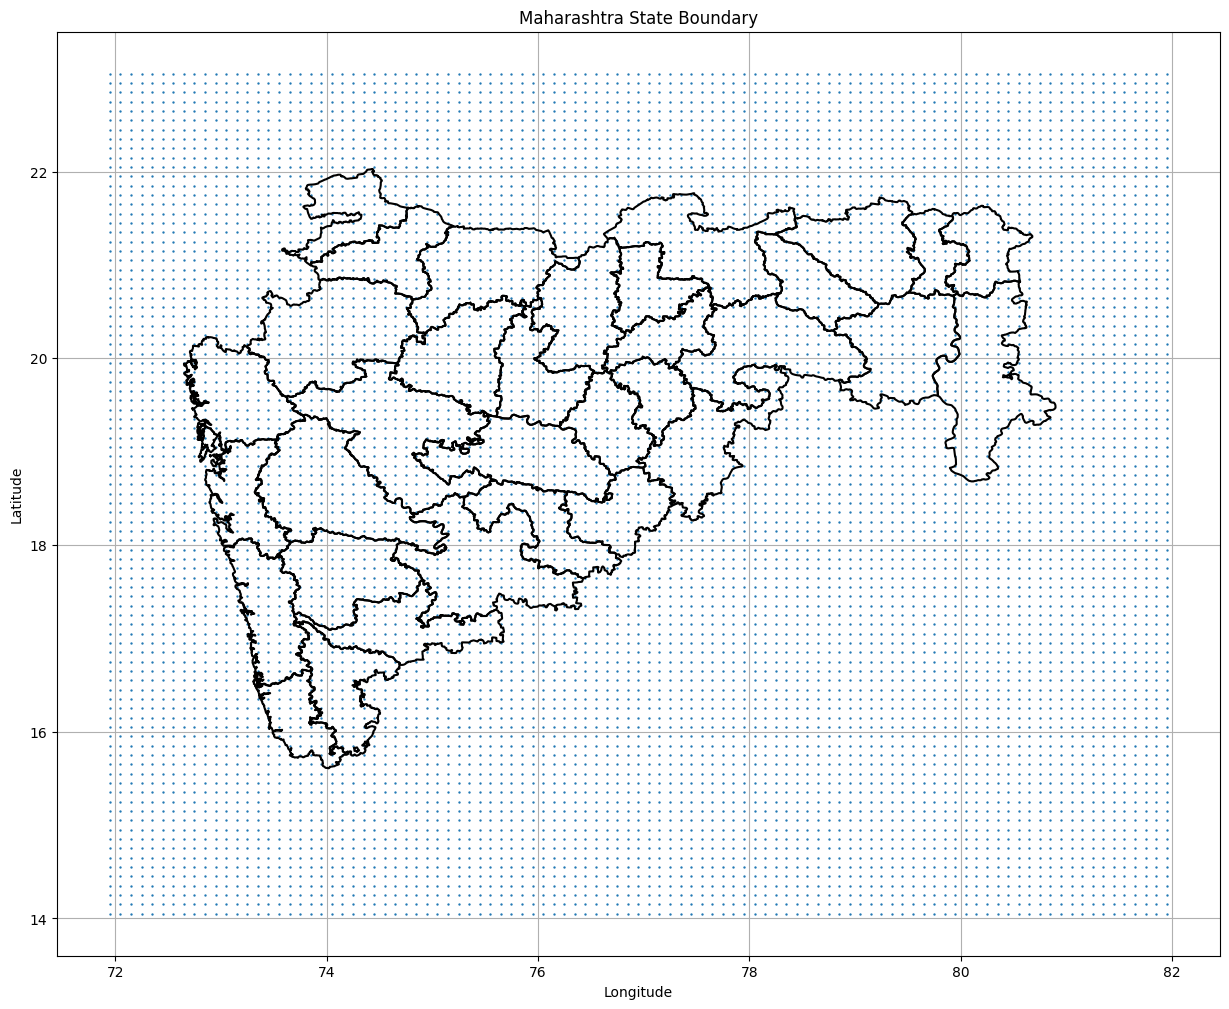

In [132]:
# Initialize shapefile reader
sf = shapefile.Reader("new_maha_district.shp")

fig, ax = plt.subplots(figsize=(15, 12))

# Loop through all shapes (district polygons)
for shape in sf.shapes():
    points = shape.points
    parts = list(shape.parts) + [len(points)]

    for i in range(len(parts) - 1):
        part_points = points[parts[i]:parts[i + 1]]
        lon, lat = zip(*part_points)
        ax.plot(lon, lat, color='black')

# --- Optional: Scatter points overlay (disabled) ---
# for loc_id in loc_ids:
#     if karnataka_test_y_pred[loc_id] == 1:
#         color = 'red'
#         alpha = 0.7
#     else:
#         color = 'green'
#         alpha = 0.5
#     plt.scatter(
#         karnataka_dataset.loc[karnataka_dataset['LOC_ID'] == loc_id, 'LONGITUDE'],
#         karnataka_dataset.loc[karnataka_dataset['LOC_ID'] == loc_id, 'LATITUDE'],
#         color=color,
#         alpha=alpha
#     )

# --- Optional: Legend (disabled) ---
# legend_elements = [
#     lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
#     lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
# ]

plt.scatter(raw_mh_dataset['LONGITUDE'], raw_mh_dataset['LATITUDE'], s=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Maharashtra State Boundary")
plt.grid(True)
# plt.legend(handles=legend_elements)
plt.show()

In [133]:
meta_data = raw_mh_dataset.iloc[:, :3]
date_data = raw_mh_dataset.iloc[:, 3:]
print(meta_data.shape)
print(date_data.shape)

date_data.columns = pd.to_datetime(date_data.columns)

mask = date_data.columns.map(
    lambda d: (d.month > 5 and d.month < 10)
)

mh_dataset_not_pre = date_data.loc[:, mask]
mh_dataset_not_pre.columns = mh_dataset_not_pre.columns.strftime('%Y-%m-%d')

loc_id = pd.Series([i for i in range(meta_data.shape[0])], name='LOC_ID')

meta_data = pd.concat([loc_id.reset_index(drop=True), meta_data.reset_index(drop=True)], axis=1)

mh_dataset_not_pre = pd.concat([meta_data, mh_dataset_not_pre], axis=1)

(9191, 3)
(9191, 2922)


In [134]:
mh_dataset_not_pre

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,71.95,14.05,70090,0.0,0.000000,0.0,0.000000,4.326894,31.442840,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,71.95,14.15,70090,0.0,0.000000,0.0,0.064278,14.200664,33.460274,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,71.95,14.25,70090,0.0,0.000000,0.0,0.064827,14.303348,28.642290,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,71.95,14.35,70090,0.0,0.000000,0.0,1.349914,11.723515,28.708788,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,71.95,14.45,70090,0.0,0.000000,0.0,5.211508,11.612844,34.883457,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,9186,81.95,22.65,70090,0.0,2.593090,0.0,0.000000,4.202532,4.015653,...,13.608622,2.417222,16.516293,1.540201,0.0,0.000000,0.000000,0.626786,3.425099,0.490838
9187,9187,81.95,22.75,70090,0.0,1.736164,0.0,0.000000,3.784898,3.892778,...,10.837712,3.196050,16.880562,2.037866,0.0,0.000000,0.000000,0.335622,2.131816,0.587263
9188,9188,81.95,22.85,70090,0.0,1.152034,0.0,0.000000,3.391212,3.688646,...,8.506171,3.598018,16.147757,2.241968,0.0,0.000000,0.000000,0.888190,0.974874,0.583566
9189,9189,81.95,22.95,70090,0.0,0.698547,0.0,0.000000,2.660206,3.330278,...,7.885351,4.207828,14.169415,2.042953,0.0,1.007939,0.734564,1.585108,0.000000,0.445981


In [135]:
# bias = 1e-3

# meta_columns = ['LOC_ID', 'LATITUDE', 'LONGITUDE', 'VALID_POINTS']

# mh_dataset = mh_dataset_not_pre.copy()

# mh_dataset.loc[:, ~mh_dataset.columns.isin(meta_columns)] = np.log1p(mh_dataset_not_pre.loc[:, ~mh_dataset.columns.isin(meta_columns)] + bias)

mh_dataset = mh_dataset_not_pre

In [136]:
mh_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-06,...,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30
0,0,71.95,14.05,70090,0.0,0.000000,0.0,0.000000,4.326894,31.442840,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,71.95,14.15,70090,0.0,0.000000,0.0,0.064278,14.200664,33.460274,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,71.95,14.25,70090,0.0,0.000000,0.0,0.064827,14.303348,28.642290,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,71.95,14.35,70090,0.0,0.000000,0.0,1.349914,11.723515,28.708788,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,71.95,14.45,70090,0.0,0.000000,0.0,5.211508,11.612844,34.883457,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,9186,81.95,22.65,70090,0.0,2.593090,0.0,0.000000,4.202532,4.015653,...,13.608622,2.417222,16.516293,1.540201,0.0,0.000000,0.000000,0.626786,3.425099,0.490838
9187,9187,81.95,22.75,70090,0.0,1.736164,0.0,0.000000,3.784898,3.892778,...,10.837712,3.196050,16.880562,2.037866,0.0,0.000000,0.000000,0.335622,2.131816,0.587263
9188,9188,81.95,22.85,70090,0.0,1.152034,0.0,0.000000,3.391212,3.688646,...,8.506171,3.598018,16.147757,2.241968,0.0,0.000000,0.000000,0.888190,0.974874,0.583566
9189,9189,81.95,22.95,70090,0.0,0.698547,0.0,0.000000,2.660206,3.330278,...,7.885351,4.207828,14.169415,2.042953,0.0,1.007939,0.734564,1.585108,0.000000,0.445981


## Generating Graphs

In [137]:
loc_ids = mh_dataset['LOC_ID'].values
print(loc_ids)

[   0    1    2 ... 9188 9189 9190]


In [138]:
years = list(range(2015, 2023))

mh_year_wise_dict = {}

year_columns = {
    year: [col for col in mh_dataset.columns if str(year) in str(col)]
    for year in years
}

col_positions = {col: i for i, col in enumerate(mh_dataset.columns)}

## itertuples is faster than iterrows, but it cannot alter the accessed data
for row in mh_dataset.itertuples(index=False):
    loc_id = row.LOC_ID

    mh_year_wise_dict[loc_id] = {}

    for year in years:
        cols = year_columns[year]

        rainfall_vector = [row[col_positions[col]] for col in cols]
        mh_year_wise_dict[loc_id][year] = np.array(rainfall_vector)

In [139]:
mh_cos_sim_dict = {}

for loc_id in loc_ids:

    vectors = [mh_year_wise_dict[loc_id][year] for year in years]
    tensor_data = torch.tensor(vectors, dtype=torch.float32)

    norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
    sim_matrix = torch.mm(norm_data, norm_data.T)

    mh_cos_sim_dict[loc_id] = sim_matrix

In [140]:
for loc_id in loc_ids: ## Mean for all graphs can be computed together
    sum = np.zeros(np.shape(mh_year_wise_dict[loc_id][2022]))

    for year in years:
        sum += mh_year_wise_dict[loc_id][year]

    mh_year_wise_dict[loc_id]['MEAN'] = sum / len(years)

In [141]:
mh_graphs = {}

for loc_id in loc_ids:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = mh_cos_sim_dict[loc_id][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [mh_year_wise_dict[loc_id]['MEAN']]

    for year in years:
        node_features.append(mh_year_wise_dict[loc_id][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    label = torch.tensor([0.5])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    mh_graphs[loc_id] = graph

## Testing the Model

In [142]:
model.eval()

mh_test_y_pred = {}

for loc_id, graph in mh_graphs.items():
    
    with torch.no_grad():
        num_nodes = graph.x.size(0)
        batch = torch.zeros(num_nodes, dtype=torch.long)
        out = model(graph.x.float(), graph.edge_index, batch)
        prediction = out.argmax(dim=1).item()

    mh_test_y_pred[loc_id] = prediction

print(len(mh_test_y_pred))

9191


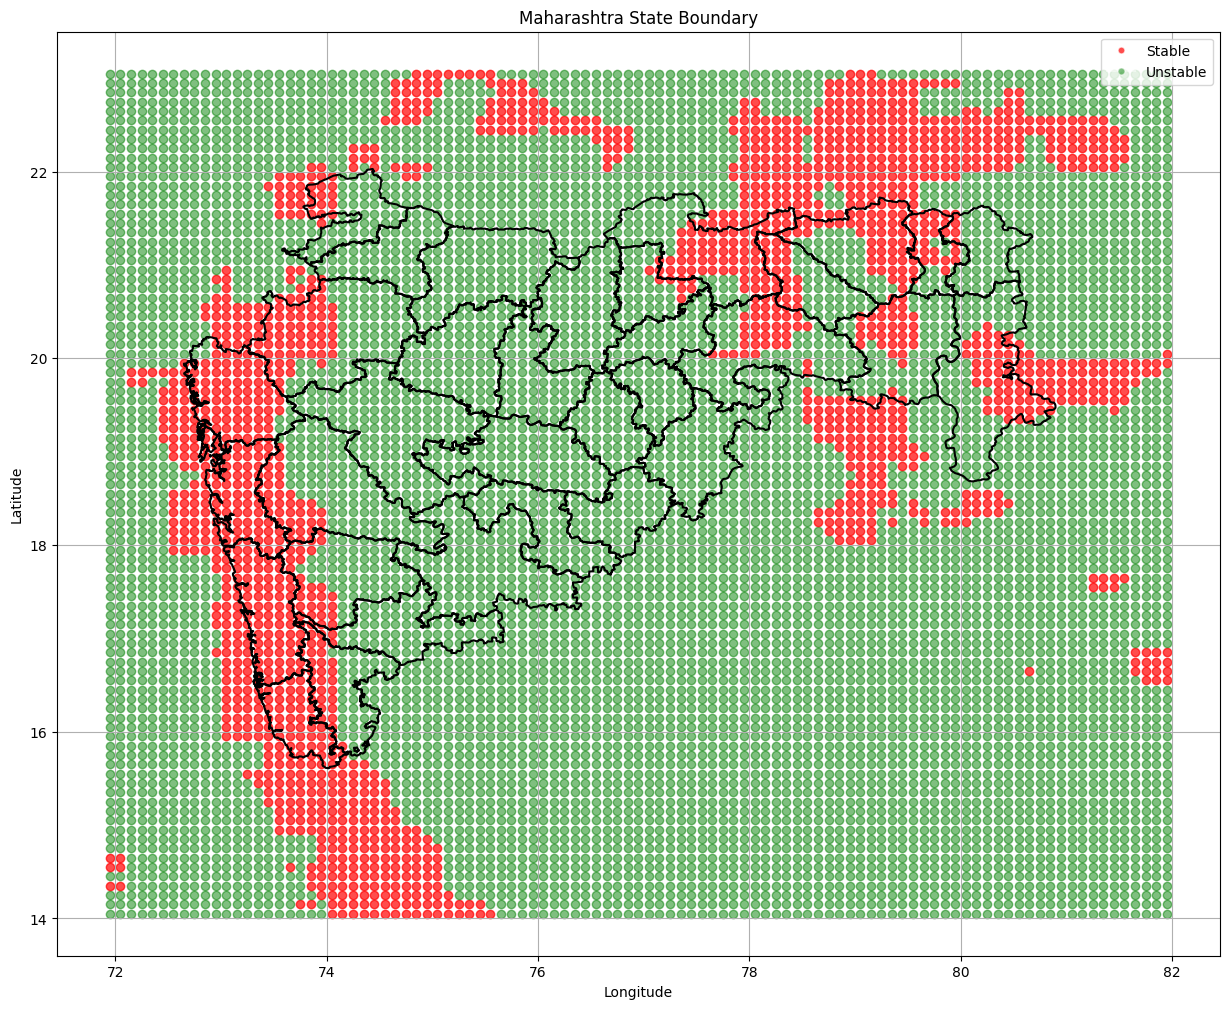

In [143]:
# Initialize shapefile reader
sf = shapefile.Reader("new_maha_district.shp")

fig, ax = plt.subplots(figsize=(15, 12))

# Loop through all shapes (district polygons)
for shape in sf.shapes():
    points = shape.points
    parts = list(shape.parts) + [len(points)]

    for i in range(len(parts) - 1):
        part_points = points[parts[i]:parts[i + 1]]
        lon, lat = zip(*part_points)
        ax.plot(lon, lat, color='black')

## --- Optional: Scatter points overlay (disabled) ---
for loc_id in loc_ids:
    if mh_test_y_pred[loc_id] == 1:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5
    plt.scatter(
        mh_dataset.loc[mh_dataset['LOC_ID'] == loc_id, 'LONGITUDE'],
        mh_dataset.loc[mh_dataset['LOC_ID'] == loc_id, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

## --- Optional: Legend (disabled) ---
legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=5, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=5, alpha=0.5)
]

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Maharashtra State Boundary")
plt.grid(True)
plt.legend(handles=legend_elements)
plt.show()